# Background and Context:

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.


Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.

 

# Data Description:

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").


# Dataset:

The dataset has the following columns:
- tweet_id                                                           
- airline_sentiment                                               
- airline_sentiment_confidence                               
- negativereason                                                   
- negativereason_confidence                                    
- airline                                                                    
- airline_sentiment_gold                                              
- name     
- negativereason_gold 
- retweet_count
- text
- tweet_coord
- tweet_created
- tweet_location 
- user_timezone

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)
sns.set()

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
from bs4 import BeautifulSoup
import re
import unicodedata
import contractions

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import spacy

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix,make_scorer

from sklearn.preprocessing import StandardScaler

import pickle   # save and load model


In [2]:
nltk.download('punkt')  # for tokenization
nltk.download('stopwords')   # for stopword removal
!python3 -m spacy download en_core_web_sm   # for lemmatization

[nltk_data] Downloading package punkt to
[nltk_data]     /home/liangym2014/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/liangym2014/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2021-10-27 16:49:28.472927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-27 16:49:28.472964: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.6 MB 4.0 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Import Data

In [3]:
airline = pd.read_csv('Tweets.csv')

In [4]:
df = airline.copy()

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df.shape

(14640, 15)

- The dataset consists of 14640 rows and 15 columns.
- Missing values present in serveral columns.
- Features with ambiguous names like `airline_sentiment_gold` and `tweet_coord` may need further investigation to understand what they really mean.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

- Most columns are objects. Only `tweet_id`, `airline_sentiment_confidence`, `negativereason_confidence` and `retweet_count` are numbers.

# Data Pre-processing
## Check Missing Values

In [8]:
# show columns with missing values and the proportion of missing values
def check_missing_values():
    miss_df = pd.DataFrame(df.isnull().sum(), columns = ['# of missing values'])
    miss_df["% of missing values"] = np.round(miss_df['# of missing values']/ df.shape[0] * 100, 2)
    return  miss_df[miss_df["# of missing values"] > 0]

In [9]:
check_missing_values()

,# of missing values,% of missing values
negativereason,5462,37.31
negativereason_confidence,4118,28.13
airline_sentiment_gold,14600,99.73
negativereason_gold,14608,99.78
tweet_coord,13621,93.04
tweet_location,4733,32.33
user_timezone,4820,32.92


- Missing values in `airline_sentiment_gold`, `negativereason_gold`, `tweet_coord` are higher than 90% of the total.
- Missing values in `negativereason`, `negativereason_confidence`, `tweet_location` and `user_timezone` account for 30% - 40% of the total.

### Drop `airline_sentiment_gold`

In [10]:
df[df.airline_sentiment_gold.notnull()]  # check airline_sentiment_gold with values

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1286,569851578276048896,negative,1.0000,Late Flight,0.7684,United,negative,MrEschatologist,Late Flight\nFlight Attendant Complaints,0,"@united I'm aware of the flight details, thanks. Three hours Late Flight a crew that could not give less of a shit",NaN,2015-02-23 05:29:38 -0800,"Arlington, VA",NaN
2017,569473998519578624,negative,1.0000,Late Flight,0.6048,United,negative,traceyabbywhite,Late Flight\nLost Luggage,0,@united flighted delayed for hours. 10pm arrival to Vegas is now 4am. Did you seriously lose my luggage???,NaN,2015-02-22 04:29:16 -0800,"Atlantic Highlands, NJ",Eastern Time (US & Canada)
2135,569343661063823360,neutral,1.0000,NaN,NaN,United,neutral,aushianya,NaN,0,@united I have a question,NaN,2015-02-21 19:51:21 -0800,NaN,NaN
2201,569318505755103232,negative,1.0000,Late Flight,0.6478,United,negative,tarlonious,Late Flight,1,@united it's been over 3 hours...at what point do you let people off of the plane? @FoxNews @CNN @msnbc,NaN,2015-02-21 18:11:23 -0800,NaN,NaN
2383,569235954789015552,negative,0.9286,Customer Service Issue,0.9286,United,negative,screamingbrat,Customer Service Issue,0,@united You shouldn't page o'head that it's best to call 1-800# - on hold 26+ mins,NaN,2015-02-21 12:43:22 -0800,"new york, baby",Eastern Time (US & Canada)
3005,568802013196242944,negative,1.0000,Can't Tell,0.6870,United,negative,katieclaytonn,Can't Tell,0,@united couldn't have possibly messed up our trip anymore than they did. Thanks for being such a terrible airline. #disappointed,NaN,2015-02-20 07:59:02 -0800,NaN,Central Time (US & Canada)
3149,568637541513089024,negative,0.9220,Customer Service Issue,0.4513,United,negative,Mosborne13,Cancelled Flight\nCustomer Service Issue,0,"@united rebooked 24 hours after original flight, to say your handling of situation was bad would be an understatement.",NaN,2015-02-19 21:05:29 -0800,NaN,Central Time (US & Canada)
4206,567778009013178368,negative,1.0000,Cancelled Flight,1.0000,United,negative,realmikesmith,Cancelled Flight,0,@united So what do you offer now that my flight was Cancelled Flighted and I'm stranded away from home and work?,"[26.37852293, -81.78472152]",2015-02-17 12:10:00 -0800,Chicago,Eastern Time (US & Canada)
4525,570066283233972224,positive,0.9657,NaN,0.0000,Southwest,positive,magmum03,NaN,0,@SouthwestAir What an awesome flight Dallas 2 NY. Virgin America refused bc of my child's peanut allergy but u guys didn't. Thanks! 👍😊,NaN,2015-02-23 19:42:47 -0800,ny,NaN
5183,569273733334077440,negative,1.0000,Customer Service Issue,0.7715,Southwest,negative,nealmo,Customer Service Issue,0,"@SouthwestAir also, gave up after 1 hr 32 minutes on hold. Maybe put a few more people on it?",NaN,2015-02-21 15:13:29 -0800,NaN,Central Time (US & Canada)


In [11]:
np.all(df.loc[df.airline_sentiment_gold.notnull(), 'airline_sentiment_gold'] == df.loc[df.airline_sentiment_gold.notnull(), 'airline_sentiment'])

True

- `airline_sentiment_gold` is the replicate of `airline_sentiment`. Drop `airline_sentiment_gold`.

In [12]:
df.drop(columns = ['airline_sentiment_gold'], inplace = True)

### Merge `negativereason` and `negativereason_gold`

In [13]:
valid_negativereasons = df[df.negativereason_gold.notnull()]  # check negativereason_gold with values
valid_negativereasons

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1286,569851578276048896,negative,1.0000,Late Flight,0.7684,United,MrEschatologist,Late Flight\nFlight Attendant Complaints,0,"@united I'm aware of the flight details, thanks. Three hours Late Flight a crew that could not give less of a shit",NaN,2015-02-23 05:29:38 -0800,"Arlington, VA",NaN
2017,569473998519578624,negative,1.0000,Late Flight,0.6048,United,traceyabbywhite,Late Flight\nLost Luggage,0,@united flighted delayed for hours. 10pm arrival to Vegas is now 4am. Did you seriously lose my luggage???,NaN,2015-02-22 04:29:16 -0800,"Atlantic Highlands, NJ",Eastern Time (US & Canada)
2201,569318505755103232,negative,1.0000,Late Flight,0.6478,United,tarlonious,Late Flight,1,@united it's been over 3 hours...at what point do you let people off of the plane? @FoxNews @CNN @msnbc,NaN,2015-02-21 18:11:23 -0800,NaN,NaN
2383,569235954789015552,negative,0.9286,Customer Service Issue,0.9286,United,screamingbrat,Customer Service Issue,0,@united You shouldn't page o'head that it's best to call 1-800# - on hold 26+ mins,NaN,2015-02-21 12:43:22 -0800,"new york, baby",Eastern Time (US & Canada)
3005,568802013196242944,negative,1.0000,Can't Tell,0.6870,United,katieclaytonn,Can't Tell,0,@united couldn't have possibly messed up our trip anymore than they did. Thanks for being such a terrible airline. #disappointed,NaN,2015-02-20 07:59:02 -0800,NaN,Central Time (US & Canada)
3149,568637541513089024,negative,0.9220,Customer Service Issue,0.4513,United,Mosborne13,Cancelled Flight\nCustomer Service Issue,0,"@united rebooked 24 hours after original flight, to say your handling of situation was bad would be an understatement.",NaN,2015-02-19 21:05:29 -0800,NaN,Central Time (US & Canada)
4206,567778009013178368,negative,1.0000,Cancelled Flight,1.0000,United,realmikesmith,Cancelled Flight,0,@united So what do you offer now that my flight was Cancelled Flighted and I'm stranded away from home and work?,"[26.37852293, -81.78472152]",2015-02-17 12:10:00 -0800,Chicago,Eastern Time (US & Canada)
5183,569273733334077440,negative,1.0000,Customer Service Issue,0.7715,Southwest,nealmo,Customer Service Issue,0,"@SouthwestAir also, gave up after 1 hr 32 minutes on hold. Maybe put a few more people on it?",NaN,2015-02-21 15:13:29 -0800,NaN,Central Time (US & Canada)
5341,569179898532761600,negative,1.0000,Customer Service Issue,0.9256,Southwest,HDTeem,Customer Service Issue,0,@SouthwestAir I've been on hold for over an hour and counting…just need a simple name change http://t.co/5Siczx1oez,NaN,2015-02-21 09:00:37 -0800,"Baton Rouge, LA",Central Time (US & Canada)
5810,568581908075933696,negative,0.9658,Bad Flight,0.6623,Southwest,abyrley,Bad Flight,1,@SouthwestAir please do something about the speed of your WiFi connections on your planes. It might as well be non-existent.,NaN,2015-02-19 17:24:25 -0800,"Raleigh, NC",NaN


In [14]:
for i, r in valid_negativereasons.iterrows():
    if r['negativereason'] not in r['negativereason_gold']:
        print(i)

12038


- `negativereason` is already included in `negativereason_gold`, except at row 12038:

In [15]:
df.loc[12038, ["negativereason", "negativereason_gold"]]

negativereason                      longlines
negativereason_gold    Customer Service Issue
Name: 12038, dtype: object

In [16]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [17]:
df.negativereason_gold.value_counts()

Customer Service Issue                      12
Late Flight                                  4
Cancelled Flight                             3
Can't Tell                                   3
Cancelled Flight\nCustomer Service Issue     2
Late Flight\nLost Luggage                    1
Late Flight\nCancelled Flight                1
Bad Flight                                   1
Lost Luggage\nDamaged Luggage                1
Customer Service Issue\nLost Luggage         1
Customer Service Issue\nCan't Tell           1
Flight Attendant Complaints                  1
Late Flight\nFlight Attendant Complaints     1
Name: negativereason_gold, dtype: int64

- It's common that customers are not content with the service in severcal aspects. 
- The unique values in `negativereason_gold` are the combinations of the unique values in `negativereason`.

**Merge two columns into one, stored in `negativereason`. Drop `negativereason_gold`.**

In [18]:
valid_negativereasons.loc[12038, 'negativereason_gold'] += '\n' + valid_negativereasons.loc[12038, 'negativereason']

for i, r in valid_negativereasons.iterrows():
    df.loc[i, 'negativereason'] = r['negativereason_gold']
    
df[df.index.isin(valid_negativereasons.index)]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1286,569851578276048896,negative,1.0000,Late Flight\nFlight Attendant Complaints,0.7684,United,MrEschatologist,Late Flight\nFlight Attendant Complaints,0,"@united I'm aware of the flight details, thanks. Three hours Late Flight a crew that could not give less of a shit",NaN,2015-02-23 05:29:38 -0800,"Arlington, VA",NaN
2017,569473998519578624,negative,1.0000,Late Flight\nLost Luggage,0.6048,United,traceyabbywhite,Late Flight\nLost Luggage,0,@united flighted delayed for hours. 10pm arrival to Vegas is now 4am. Did you seriously lose my luggage???,NaN,2015-02-22 04:29:16 -0800,"Atlantic Highlands, NJ",Eastern Time (US & Canada)
2201,569318505755103232,negative,1.0000,Late Flight,0.6478,United,tarlonious,Late Flight,1,@united it's been over 3 hours...at what point do you let people off of the plane? @FoxNews @CNN @msnbc,NaN,2015-02-21 18:11:23 -0800,NaN,NaN
2383,569235954789015552,negative,0.9286,Customer Service Issue,0.9286,United,screamingbrat,Customer Service Issue,0,@united You shouldn't page o'head that it's best to call 1-800# - on hold 26+ mins,NaN,2015-02-21 12:43:22 -0800,"new york, baby",Eastern Time (US & Canada)
3005,568802013196242944,negative,1.0000,Can't Tell,0.6870,United,katieclaytonn,Can't Tell,0,@united couldn't have possibly messed up our trip anymore than they did. Thanks for being such a terrible airline. #disappointed,NaN,2015-02-20 07:59:02 -0800,NaN,Central Time (US & Canada)
3149,568637541513089024,negative,0.9220,Cancelled Flight\nCustomer Service Issue,0.4513,United,Mosborne13,Cancelled Flight\nCustomer Service Issue,0,"@united rebooked 24 hours after original flight, to say your handling of situation was bad would be an understatement.",NaN,2015-02-19 21:05:29 -0800,NaN,Central Time (US & Canada)
4206,567778009013178368,negative,1.0000,Cancelled Flight,1.0000,United,realmikesmith,Cancelled Flight,0,@united So what do you offer now that my flight was Cancelled Flighted and I'm stranded away from home and work?,"[26.37852293, -81.78472152]",2015-02-17 12:10:00 -0800,Chicago,Eastern Time (US & Canada)
5183,569273733334077440,negative,1.0000,Customer Service Issue,0.7715,Southwest,nealmo,Customer Service Issue,0,"@SouthwestAir also, gave up after 1 hr 32 minutes on hold. Maybe put a few more people on it?",NaN,2015-02-21 15:13:29 -0800,NaN,Central Time (US & Canada)
5341,569179898532761600,negative,1.0000,Customer Service Issue,0.9256,Southwest,HDTeem,Customer Service Issue,0,@SouthwestAir I've been on hold for over an hour and counting…just need a simple name change http://t.co/5Siczx1oez,NaN,2015-02-21 09:00:37 -0800,"Baton Rouge, LA",Central Time (US & Canada)
5810,568581908075933696,negative,0.9658,Bad Flight,0.6623,Southwest,abyrley,Bad Flight,1,@SouthwestAir please do something about the speed of your WiFi connections on your planes. It might as well be non-existent.,NaN,2015-02-19 17:24:25 -0800,"Raleigh, NC",NaN


In [19]:
df.drop(columns = ['negativereason_gold'], inplace = True)

In [20]:
check_missing_values()

,# of missing values,% of missing values
negativereason,5462,37.31
negativereason_confidence,4118,28.13
tweet_coord,13621,93.04
tweet_location,4733,32.33
user_timezone,4820,32.92


### Check the relation between `airline_sentiment` and `negativereason`, `negativereason_confidence`

In [21]:
df.loc[df.negativereason.isnull(), 'airline_sentiment'].value_counts()

neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [22]:
df.loc[df.negativereason_confidence.isnull(), 'airline_sentiment'].value_counts()

neutral     2085
positive    2033
Name: airline_sentiment, dtype: int64

- The missing values in `negativereason` and `negativereason_confidence` correspond to positive or neutral sentiment. So they're actually "N/A" rather than missing.

In [23]:
df['negativereason'].fillna("NA", inplace = True)
df['negativereason_confidence'].fillna(0, inplace = True)

### Drop `tweet_coord`

In [24]:
df.tweet_coord.value_counts()[:10]

[0.0, 0.0]                      164
[40.64656067, -73.78334045]       6
[32.91792297, -97.00367737]       3
[40.64646912, -73.79133606]       3
[33.75539049, -116.36196163]      2
[39.1766101, -76.6700606]         2
[34.0213466, -118.45229268]       2
[40.69017276, -73.91646118]       2
[40.68994668, -73.91637642]       2
[40.69002464, -73.91638072]       2
Name: tweet_coord, dtype: int64

- `tweet_coord` is the coordinates of the contributors. Drop it.

In [25]:
df.drop(columns = ['tweet_coord'], inplace = True)

## Drop `tweet_id` and `name`
- `tweet_id` and `name` don't contain useful information for our prediction. Drop them.

In [26]:
df.drop(columns = ['tweet_id', 'name'], inplace = True)

## Check unique values

In [27]:
for col in df.columns:
    print(col, ":", df[col].nunique())

airline_sentiment : 3
airline_sentiment_confidence : 1023
negativereason : 19
negativereason_confidence : 1410
airline : 6
retweet_count : 18
text : 14427
tweet_created : 14247
tweet_location : 3081
user_timezone : 85


## Check `tweet_location`

In [28]:
list(df.tweet_location.unique()[:30])  # show 30 of tweet locations

[nan,
 'Lets Play',
 'San Francisco CA',
 'Los Angeles',
 'San Diego',
 '1/1 loner squad',
 'NYC',
 'San Francisco, CA',
 'palo alto, ca',
 'west covina',
 'this place called NYC',
 'Somewhere celebrating life. ',
 'Boston | Waltham',
 'Boston, MA ',
 '714',
 'San Mateo, CA & Las Vegas, NV',
 'Brooklyn',
 'California, San Francisco',
 'Washington DC',
 'Texas',
 'Worldwide',
 'Central Texas',
 "i'm creating a monster ",
 'Iowa City',
 'Georgia',
 'Turks and caicos',
 'Oakland via Midwest ',
 'New York, NY',
 'Northern Virginia',
 'Los Angeles / Atlanta']

- Representations of `tweet_location` are flexible. Some are real geographic locations, while others are not. 
- Granularity of geographic locations is from borough/city to state/country. 

## Split `tweet_created` into year, month, day and hour

In [29]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

In [30]:
df['year'] = df['tweet_created'].dt.year
df['month'] = df['tweet_created'].dt.month
df['day'] = df['tweet_created'].dt.day
df['hour'] = df['tweet_created'].dt.hour

In [31]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
0,neutral,1.0000,NA,0.0000,Virgin America,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada),2015,2,24,11
1,positive,0.3486,NA,0.0000,Virgin America,0,@VirginAmerica plus you've added commercials to the experience... tacky.,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada),2015,2,24,11
2,neutral,0.6837,NA,0.0000,Virgin America,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada),2015,2,24,11
3,negative,1.0000,Bad Flight,0.7033,Virgin America,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada),2015,2,24,11
4,negative,1.0000,Can't Tell,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing about it,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada),2015,2,24,11


## Data description

In [32]:
df.describe(include = ['object'])

,airline_sentiment,negativereason,airline,text,tweet_location,user_timezone
count,14640,14640,14640,14640,9907,9820
unique,3,19,6,14427,3081,85
top,negative,NA,United,@united thanks,"Boston, MA",Eastern Time (US & Canada)
freq,9178,5462,3822,6,157,3744


In [33]:
df.describe()

,airline_sentiment_confidence,negativereason_confidence,retweet_count,year,month,day,hour
count,14640.000000,14640.000000,14640.000000,14640.0,14640.0,14640.000000,14640.000000
mean,0.900169,0.458755,0.082650,2015.0,2.0,20.947473,12.319945
std,0.162830,0.401057,0.745778,0.0,0.0,2.170646,5.306285
min,0.335000,0.000000,0.000000,2015.0,2.0,16.000000,0.000000
25%,0.692300,0.000000,0.000000,2015.0,2.0,19.000000,8.000000
50%,1.000000,0.624600,0.000000,2015.0,2.0,22.000000,12.000000
75%,1.000000,0.703300,0.000000,2015.0,2.0,23.000000,17.000000
max,1.000000,1.000000,44.000000,2015.0,2.0,24.000000,23.000000


- Most of the sentiments are negative.
- Among six airlines, United appears most frequently.
- About 30% contributors are from Eastern Time (US & Canada) time zone.
- Data was collected during 2015-2-16 to 2015-2-24.
- Most of the tweets don't get retweeted. But some outliers get as many as 44 retweets.

# EDA
## Univariate Analysis

In [34]:
num_categories = 40   # the maximum categories being shown in countplot

def count_plotx(col, first_n = 0):
    """
    Show a vertical countplot of the first_n categories.
    """
    if df[col].nunique() < num_categories:   # if number of categories < num_categories, display all of them. otherwise, only display first_n categories.
        first_n = df[col].nunique()
    ax = sns.countplot(x = df[col], order = df[col].value_counts().index[:first_n])
    for p in ax.patches:
        percent = np.round(p.get_height() / df.shape[0] * 100, 2)
        plt.annotate(str(percent) + '%', (p.get_x() + p.get_width()/2 - 0.2, p.get_y() + p.get_height()))
        
def count_ploty(col, first_n = 0):
    """
    Show a horizontal countplot of the first_n categories.
    """    
    if df[col].nunique() < num_categories:   # if number of categories < num_categories, display all of them. otherwise, only display first_n categories.
        first_n = df[col].nunique()
    ax = sns.countplot(y = df[col], order = df[col].value_counts().index[:first_n])
    for p in ax.patches:
        percent = np.round(p.get_width() / df.shape[0] * 100, 2)
        plt.annotate(str(percent) + '%', (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2))        

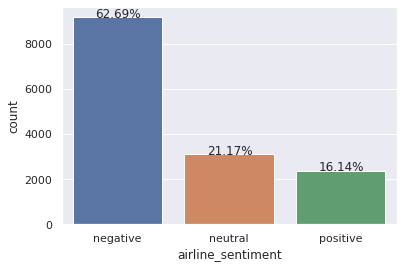

In [35]:
count_plotx('airline_sentiment')   # distribution of sentiment across all the tweets

- Negative reviews account for 62.69%, followed by neutral reviews of 21.17%.

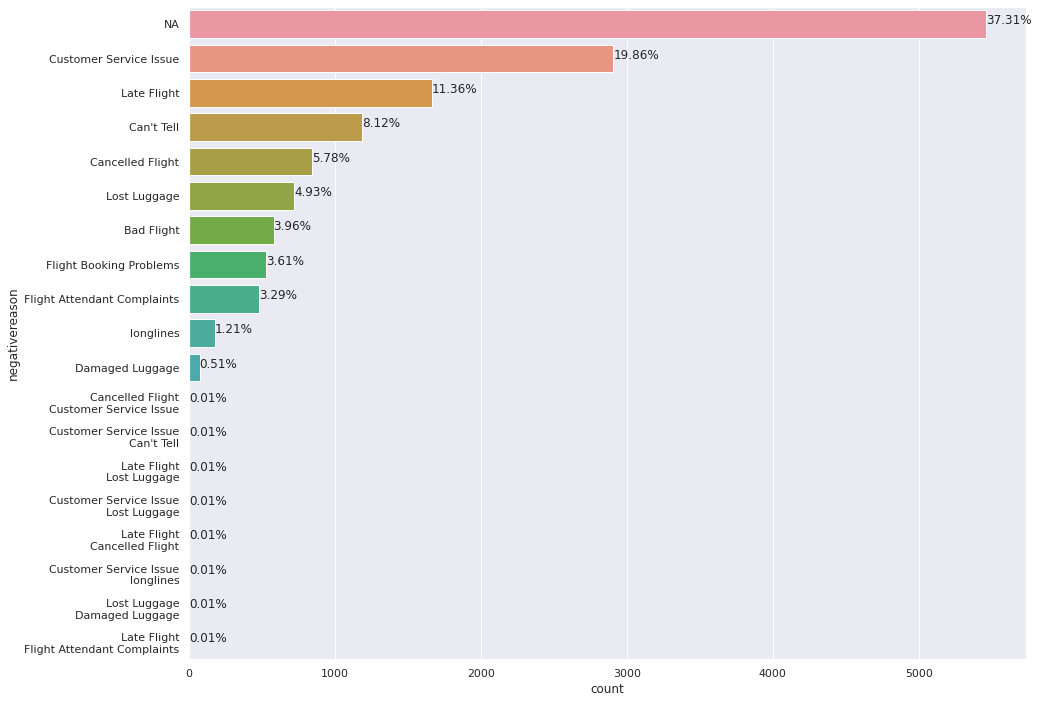

In [36]:
plt.figure(figsize = (15,12))
count_ploty('negativereason')    # distribution of all the negative reasons

- `Customer Service Issue` accounts for about 20% of negative reasons, followed by `Late Flight`. It's noticeable that the #3 negative reason is `Can't Tell`. It deserves further research on what it actually means. It may indicate customers are not comfortable with the service in many minor and subtle ways.
- Less than 1% complaints associate with multiple negative reasons.

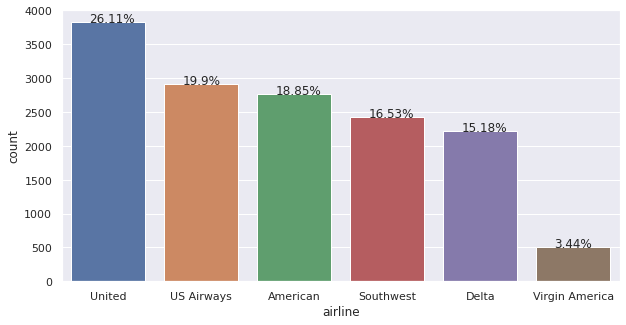

In [37]:
plt.figure(figsize = (10,5))
count_plotx('airline')     # distribution of all tweets among each airline

- Totally 6 airlines. 26.11% of the reviews are about `United`, followed by `US Airways` of 19.9% and `American` of 18.85%.

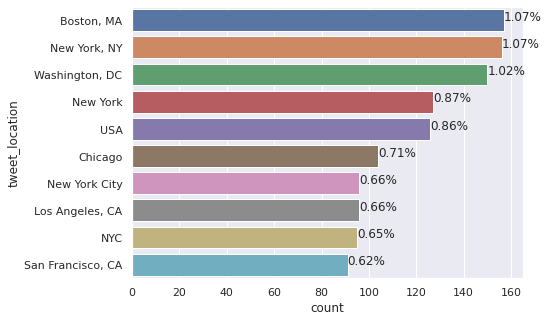

In [38]:
plt.figure(figsize = (7,5))
count_ploty('tweet_location', 10)

- Top 10 tweet locations are all in USA.

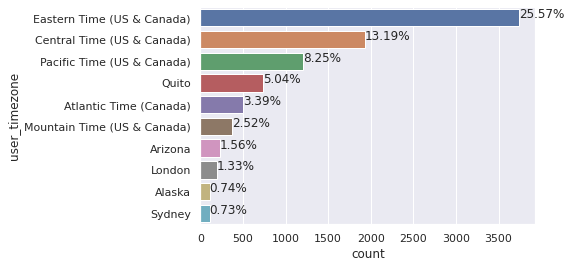

In [39]:
count_ploty('user_timezone', 10)

- Among top 10 user timezones, most are located at North America. About 5% are from Quito, Ecuador.

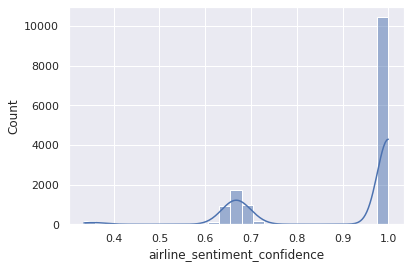

In [40]:
sns.histplot(df['airline_sentiment_confidence'], kde = True);

- `airline_sentiment_confidence` are mostly 1.0. But it's unclear what this feature exactly means.

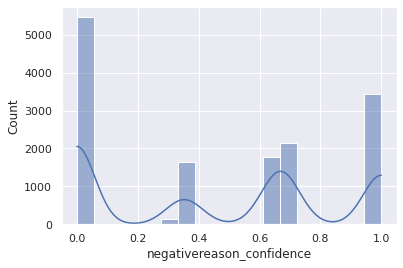

In [41]:
sns.histplot(df['negativereason_confidence'], kde = True);

- `negativereason_confidence` are approaching to either 0 or 1. But it's unclear what this feature exactly means.

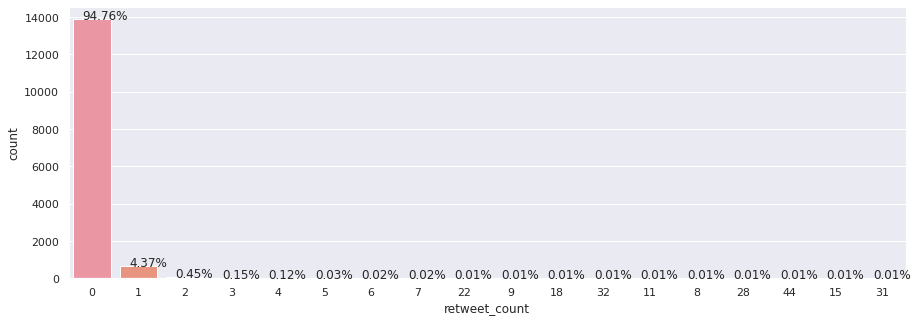

In [42]:
plt.figure(figsize = (15,5))
count_plotx('retweet_count')

- 95% of the tweets don't get retweeted. But some outliers could get retweeted for as many as 44 times:

In [43]:
df[df.retweet_count == 44]

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,text,tweet_created,tweet_location,user_timezone,year,month,day,hour
11596,negative,1.0,Late Flight,1.0,US Airways,44,"@USAirways 5 hr flight delay and a delay when we land . Is that even real life ? Get me off this plane , I wanna go home 👠👠👠 (3 heel clicks)",2015-02-17 20:06:21-08:00,NaN,Eastern Time (US & Canada),2015,2,17,20


- The one that got so many retweets is about a 5 hour delay flight with US Airways. Probably retweets are from other passengers who were also delayed in the same flight.

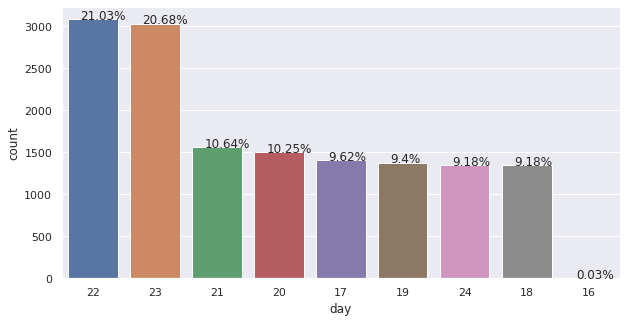

In [44]:
plt.figure(figsize = (10,5))
count_plotx('day')

- 40% of the data was collected during 2015-2-22 to 2015-2-23, although the data collecting began on 2015-2-16.

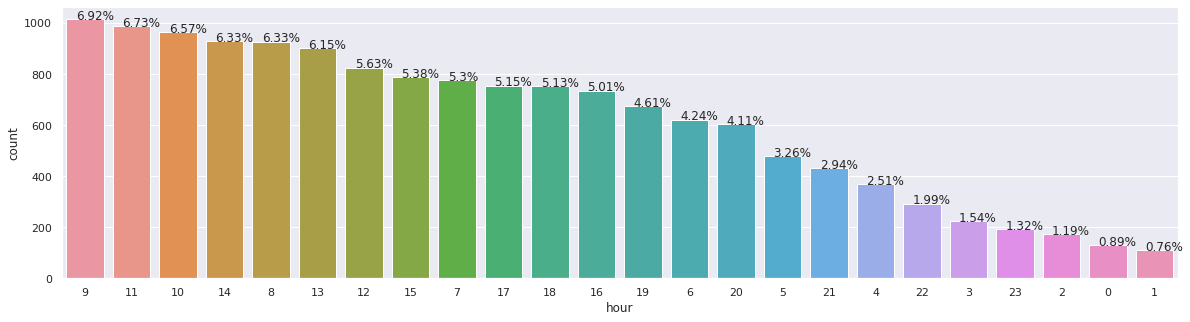

In [45]:
plt.figure(figsize = (20,5))
count_plotx('hour')

- Most of the tweets were created during 7:00 - 18:00. Part of them were created during unusual time slots between 22:00 - 4:00.

## Bivariate Analysis
### `airline_sentiment` vs `airline`

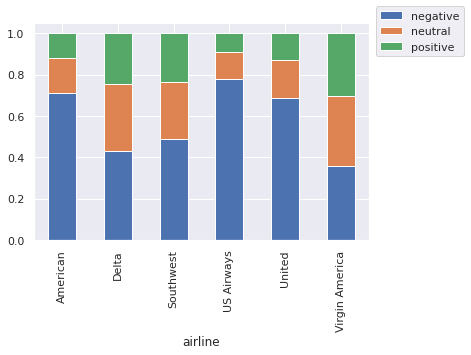

In [46]:
pd.crosstab(index = df.airline, columns = df.airline_sentiment, normalize = 'index').plot(kind = 'bar', 
                                                                                          stacked = True);  # distribution of Sentiment of tweets for each airline
plt.legend(bbox_to_anchor = (1.3,1.1), loc = 'upper right');

- At least 70% of the sentiments about `America`, `US Airways` and `United` are negative.
- `Virgin America` is more welcomed by customers, with less than 40% of negative feedbacks and about 30% positive feedbacks.

### `negativereason` vs `airline`

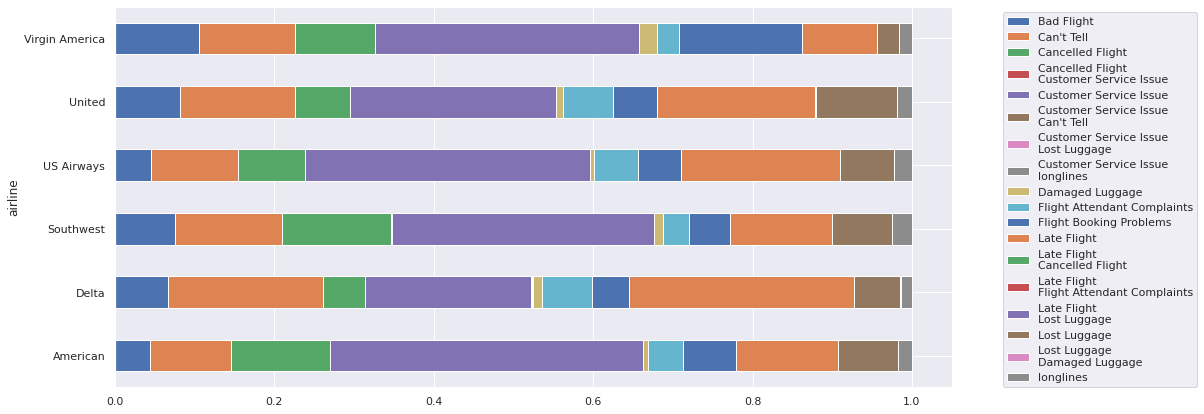

In [47]:
# distribution of negative reasons for each airline
pd.crosstab(index = df[df.negativereason != "NA"].airline, columns = df[df.negativereason != "NA"].negativereason, 
            normalize = 'index').plot(kind = 'barh', stacked = True, figsize = (15,7));    # excluding negativereason == "NA"
plt.legend(bbox_to_anchor = (1.3,1), loc = 'best');

- About 40% of the complaints about `American`/ `Southwest`/ `US Airways` are related to "Customer Service Issue".
- "Late Flight" is the #1 complaint about `Delta`.
- For each airline except `Virgin America`, "Late Flight" and "Customer Service Issue" are two major complaints.
- Besides "Customer Service Issue" being the #1 concern, "Flight Booking Problems" contributes to about 20% of the complaints about `Virgin America`.

### WordCloud for positive sentiment

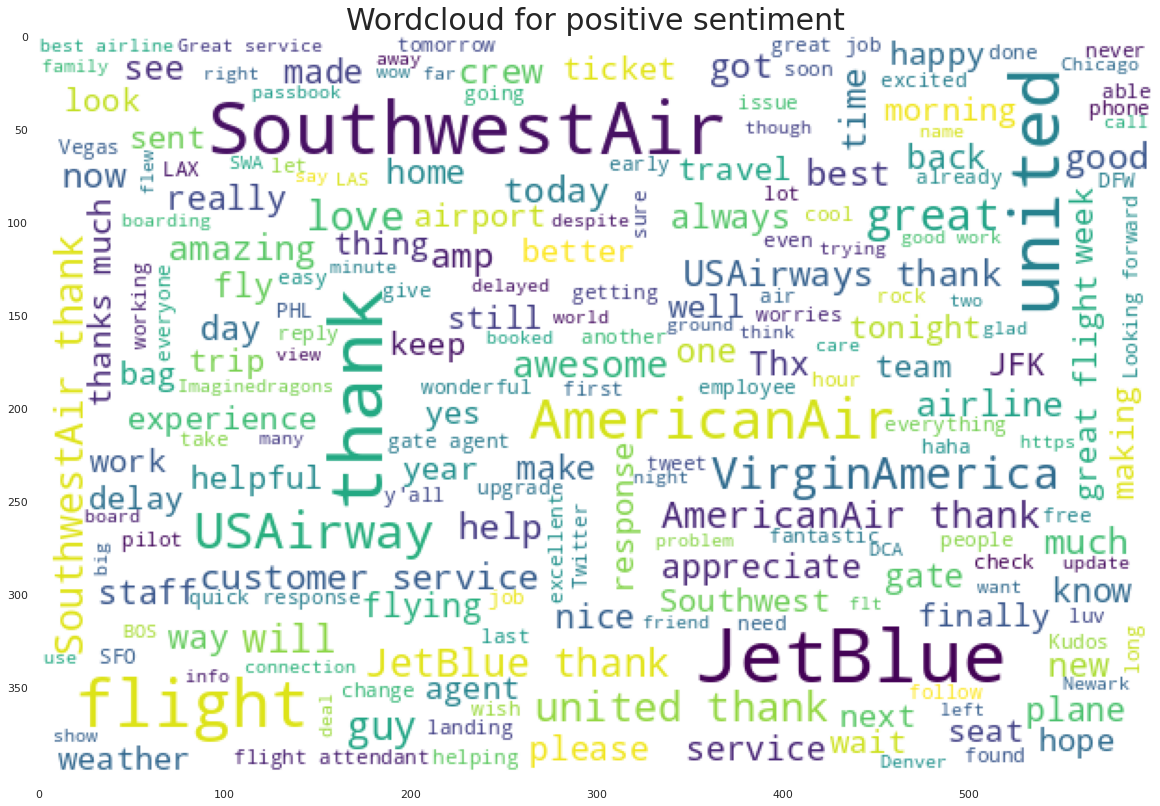

In [48]:
positive_text = df.loc[df['airline_sentiment'] == 'positive', 'text'].values
positive_text = ' '.join(positive_text)
plt.figure(figsize = (20, 20))
plt.grid(False)
plt.imshow(WordCloud(width=600, height=400,background_color = "white", 
                     max_font_size = 40,min_font_size = 10, max_words = 300, min_word_length = 3).generate(positive_text));
plt.title("Wordcloud for positive sentiment", fontsize = 30);

- In the wordcloud of positive sentiment, words that pop up frequently are: wonderful, thank, best, happy, great, awesome, amazing, love, helpful, appreciate, well, nice, fantastic, etc .

### WordCloud for negative sentiment

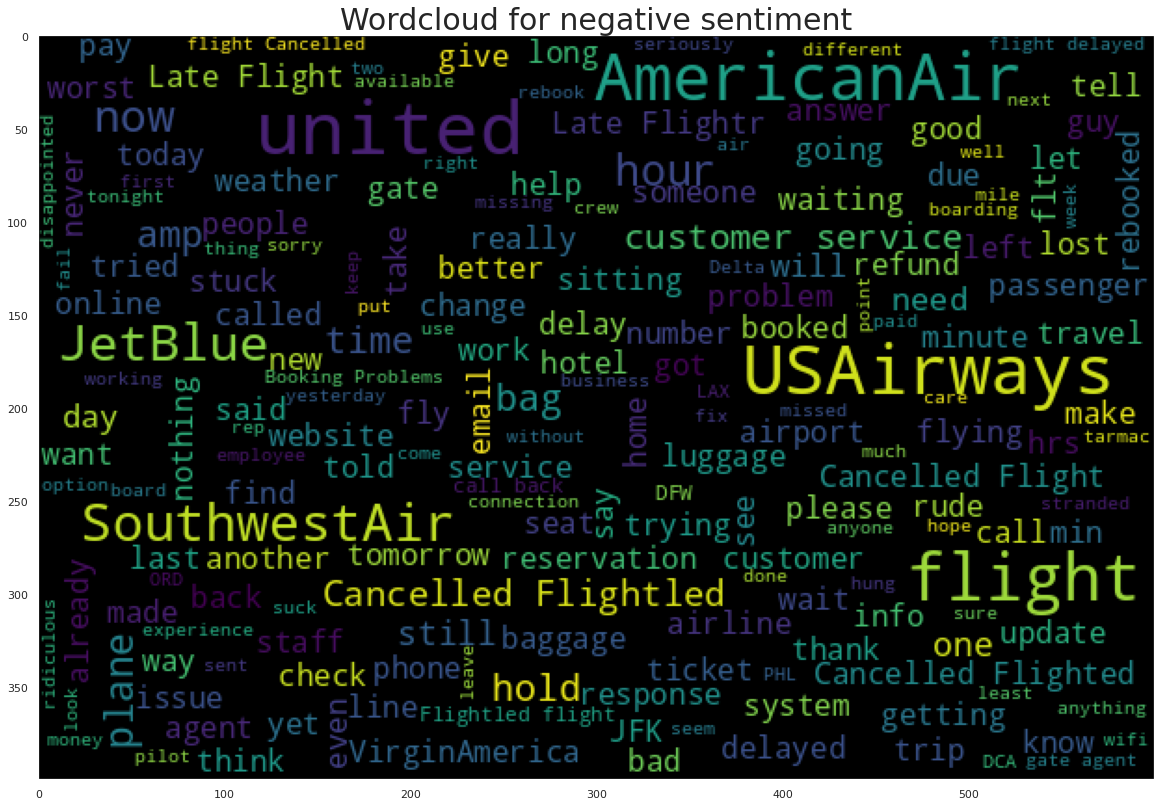

In [49]:
negative_text = df.loc[df['airline_sentiment'] == 'negative', 'text'].values
negative_text = ' '.join(negative_text)
plt.figure(figsize = (20, 20))
plt.grid(False)
plt.imshow(WordCloud(width=600, height=400,background_color = "black", 
                     max_font_size = 40,min_font_size = 10, max_words = 300, min_word_length = 3).generate(negative_text));
plt.title("Wordcloud for negative sentiment", fontsize = 30);

- In the wordcloud of negative sentiment, words that pop up frequently are: worst, rude, disappointed, problem, fail, refund, cancalled, late, delayed, bad, lost, ridiculous, etc.

# Data Pre-processing
## Drop all the columns except `text` and `airline_sentiment`

In [50]:
df = df[["text","airline_sentiment"]]
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


In [51]:
df.shape

(14640, 2)

- Randomly sample 10 reviews:

In [52]:
samples = df.sample(10, random_state = 8)
samples

,text,airline_sentiment
6046,"@SouthwestAir aww thanks!! Other than that, love it!",positive
10963,@USAirways @AmericanAir I'm in the #finalstretch to #chairman #execplat #mileagerun for 6k needed any suggestions? #letsgo!,neutral
758,@united we just flew with United from AUS (Austin Bergstrom) to Cancun Intl. Best flight ever! The 737's are not too big... Not too small!,positive
12064,@AmericanAir thanks,positive
12923,@AmericanAir I still can't get through to change my flight. This is really important plz help!,negative
12061,@AmericanAir your planes made me miss 2 connections in 2 days. Thanks for nothing,negative
4479,"@SouthwestAir I ""heart"" Southwest but those commercials aimed to satisfy a nano-smattering of travelers to few destinations.",negative
4933,@SouthwestAir Thanks. 436. Only a minor delay so not a big deal. :)Appreciate the concern though. Boarding now. You do have amazing service!,positive
5922,"@SouthwestAir thanks for your attention, I've been flying southwest for 3 years and haven't had this issue in the past.",positive
6022,@SouthwestAir guess where Ashley is. She's doing a great job presenting. #ragandisney http://t.co/5ZNMwxDI9U,positive


- Besides the text, there're super links, mentions, hashtags and emojis in the review, which should be removed before model building.

## Html tag removal

In [53]:
def remove_html(text):
    return BeautifulSoup(text, 'html.parser').get_text()

In [54]:
samples["text"] = samples["text"].apply(lambda x: remove_html(x))
samples

,text,airline_sentiment
6046,"@SouthwestAir aww thanks!! Other than that, love it!",positive
10963,@USAirways @AmericanAir I'm in the #finalstretch to #chairman #execplat #mileagerun for 6k needed any suggestions? #letsgo!,neutral
758,@united we just flew with United from AUS (Austin Bergstrom) to Cancun Intl. Best flight ever! The 737's are not too big... Not too small!,positive
12064,@AmericanAir thanks,positive
12923,@AmericanAir I still can't get through to change my flight. This is really important plz help!,negative
12061,@AmericanAir your planes made me miss 2 connections in 2 days. Thanks for nothing,negative
4479,"@SouthwestAir I ""heart"" Southwest but those commercials aimed to satisfy a nano-smattering of travelers to few destinations.",negative
4933,@SouthwestAir Thanks. 436. Only a minor delay so not a big deal. :)Appreciate the concern though. Boarding now. You do have amazing service!,positive
5922,"@SouthwestAir thanks for your attention, I've been flying southwest for 3 years and haven't had this issue in the past.",positive
6022,@SouthwestAir guess where Ashley is. She's doing a great job presenting. #ragandisney http://t.co/5ZNMwxDI9U,positive


## Remove the numbers

In [55]:
def remove_numbers(text):
    return re.sub(r'\d', '', text)

In [56]:
samples["text"] = samples["text"].apply(lambda x: remove_numbers(x))
samples

,text,airline_sentiment
6046,"@SouthwestAir aww thanks!! Other than that, love it!",positive
10963,@USAirways @AmericanAir I'm in the #finalstretch to #chairman #execplat #mileagerun for k needed any suggestions? #letsgo!,neutral
758,@united we just flew with United from AUS (Austin Bergstrom) to Cancun Intl. Best flight ever! The 's are not too big... Not too small!,positive
12064,@AmericanAir thanks,positive
12923,@AmericanAir I still can't get through to change my flight. This is really important plz help!,negative
12061,@AmericanAir your planes made me miss connections in days. Thanks for nothing,negative
4479,"@SouthwestAir I ""heart"" Southwest but those commercials aimed to satisfy a nano-smattering of travelers to few destinations.",negative
4933,@SouthwestAir Thanks. . Only a minor delay so not a big deal. :)Appreciate the concern though. Boarding now. You do have amazing service!,positive
5922,"@SouthwestAir thanks for your attention, I've been flying southwest for years and haven't had this issue in the past.",positive
6022,@SouthwestAir guess where Ashley is. She's doing a great job presenting. #ragandisney http://t.co/ZNMwxDIU,positive


## Expand contractions

In [57]:
def remove_contractions(text):
    return contractions.fix(text)

In [58]:
samples["text"] = samples["text"].apply(lambda x: remove_contractions(x))
samples

,text,airline_sentiment
6046,"@SouthwestAir aww thanks!! Other than that, love it!",positive
10963,@USAirways @AmericanAir I am in the #finalstretch to #chairman #execplat #mileagerun for k needed any suggestions? #letsgo!,neutral
758,@united we just flew with United from AUS (Austin Bergstrom) to Cancun Intl. Best flight ever! The 's are not too big... Not too small!,positive
12064,@AmericanAir thanks,positive
12923,@AmericanAir I still cannot get through to change my flight. This is really important plz help!,negative
12061,@AmericanAir your planes made me miss connections in days. Thanks for nothing,negative
4479,"@SouthwestAir I ""heart"" Southwest but those commercials aimed to satisfy a nano-smattering of travelers to few destinations.",negative
4933,@SouthwestAir Thanks. . Only a minor delay so not a big deal. :)Appreciate the concern though. Boarding now. You do have amazing service!,positive
5922,"@SouthwestAir thanks for your attention, I have been flying southwest for years and have not had this issue in the past.",positive
6022,@SouthwestAir guess where Ashley is. she is doing a great job presenting. #ragandisney http://t.co/ZNMwxDIU,positive


## Removal of Special Characters and Punctuations

In [59]:
def remove_specialchars_punctuations(text):
    text = unicodedata.normalize('NFKD', text).encode("ascii", 'ignore').decode("utf-8", 'ignore')   # replace non-ascii characters with ascii characters
    text = re.sub(r'\@(\w+)', '', text)  # remove mentions
    return re.sub(r'[^\w\s]', '', text)   # remove punctuations

In [60]:
samples["text"] = samples["text"].apply(lambda x: remove_specialchars_punctuations(x))
samples

,text,airline_sentiment
6046,aww thanks Other than that love it,positive
10963,I am in the finalstretch to chairman execplat mileagerun for k needed any suggestions letsgo,neutral
758,we just flew with United from AUS Austin Bergstrom to Cancun Intl Best flight ever The s are not too big Not too small,positive
12064,thanks,positive
12923,I still cannot get through to change my flight This is really important plz help,negative
12061,your planes made me miss connections in days Thanks for nothing,negative
4479,I heart Southwest but those commercials aimed to satisfy a nanosmattering of travelers to few destinations,negative
4933,Thanks Only a minor delay so not a big deal Appreciate the concern though Boarding now You do have amazing service,positive
5922,thanks for your attention I have been flying southwest for years and have not had this issue in the past,positive
6022,guess where Ashley is she is doing a great job presenting ragandisney httptcoZNMwxDIU,positive


## Convert to lowercase

In [61]:
def to_lowercase(text):
    return text.lower()

In [62]:
samples["text"] = samples["text"].apply(lambda x: to_lowercase(x))
samples

,text,airline_sentiment
6046,aww thanks other than that love it,positive
10963,i am in the finalstretch to chairman execplat mileagerun for k needed any suggestions letsgo,neutral
758,we just flew with united from aus austin bergstrom to cancun intl best flight ever the s are not too big not too small,positive
12064,thanks,positive
12923,i still cannot get through to change my flight this is really important plz help,negative
12061,your planes made me miss connections in days thanks for nothing,negative
4479,i heart southwest but those commercials aimed to satisfy a nanosmattering of travelers to few destinations,negative
4933,thanks only a minor delay so not a big deal appreciate the concern though boarding now you do have amazing service,positive
5922,thanks for your attention i have been flying southwest for years and have not had this issue in the past,positive
6022,guess where ashley is she is doing a great job presenting ragandisney httptcoznmwxdiu,positive


## Tokenization

In [63]:
def tokenize(text):
    return word_tokenize(text)

In [64]:
samples["text"] = samples["text"].apply(lambda x: tokenize(x))
samples

,text,airline_sentiment
6046,"[aww, thanks, other, than, that, love, it]",positive
10963,"[i, am, in, the, finalstretch, to, chairman, execplat, mileagerun, for, k, needed, any, suggestions, letsgo]",neutral
758,"[we, just, flew, with, united, from, aus, austin, bergstrom, to, cancun, intl, best, flight, ever, the, s, are, not, too, big, not, too, small]",positive
12064,[thanks],positive
12923,"[i, still, can, not, get, through, to, change, my, flight, this, is, really, important, plz, help]",negative
12061,"[your, planes, made, me, miss, connections, in, days, thanks, for, nothing]",negative
4479,"[i, heart, southwest, but, those, commercials, aimed, to, satisfy, a, nanosmattering, of, travelers, to, few, destinations]",negative
4933,"[thanks, only, a, minor, delay, so, not, a, big, deal, appreciate, the, concern, though, boarding, now, you, do, have, amazing, service]",positive
5922,"[thanks, for, your, attention, i, have, been, flying, southwest, for, years, and, have, not, had, this, issue, in, the, past]",positive
6022,"[guess, where, ashley, is, she, is, doing, a, great, job, presenting, ragandisney, httptcoznmwxdiu]",positive


## Removal of stopwords
- Check the content in stopword list:

In [65]:
stopword_list = stopwords.words('english')
stopword_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

- Remove negations like "no", "not", "nor" and add additional stop words such as names of airlines to stopword_list.

In [66]:
stopword_list = set(stopword_list)  # convert the list into set
stopword_list -= set(["no", "not", "nor"])
stopword_list |= set(["united", "us", "airways", "usairway", "usairways", "american", "southwest", "southwestair", "delta", "virgin", "america", "virginamerica",
                      "americanair", "jetblue"])
stopword_list

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'airways',
 'all',
 'am',
 'america',
 'american',
 'americanair',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'delta',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'jetblue',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',

In [67]:
def remove_stopwords(text):
    return [x for x in text if x not in stopword_list]

In [68]:
samples["text"] = samples["text"].apply(lambda x: remove_stopwords(x))
samples

,text,airline_sentiment
6046,"[aww, thanks, love]",positive
10963,"[finalstretch, chairman, execplat, mileagerun, k, needed, suggestions, letsgo]",neutral
758,"[flew, aus, austin, bergstrom, cancun, intl, best, flight, ever, not, big, not, small]",positive
12064,[thanks],positive
12923,"[still, not, get, change, flight, really, important, plz, help]",negative
12061,"[planes, made, miss, connections, days, thanks, nothing]",negative
4479,"[heart, commercials, aimed, satisfy, nanosmattering, travelers, destinations]",negative
4933,"[thanks, minor, delay, not, big, deal, appreciate, concern, though, boarding, amazing, service]",positive
5922,"[thanks, attention, flying, years, not, issue, past]",positive
6022,"[guess, ashley, great, job, presenting, ragandisney, httptcoznmwxdiu]",positive


## Lemmatize or stemming

In [69]:
nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
    doc = nlp(' '.join(text))
    return ' '.join([x.lemma_ for x in doc])   # Join the words in the list to convert back to text string

In [70]:
samples["text"] = samples["text"].apply(lambda x: lemmatize(x))
samples

,text,airline_sentiment
6046,aww thank love,positive
10963,finalstretch chairman execplat mileagerun k need suggestion letsgo,neutral
758,fly aus austin bergstrom cancun intl good flight ever not big not small,positive
12064,thank,positive
12923,still not get change flight really important plz help,negative
12061,plane make miss connection day thank nothing,negative
4479,heart commercial aim satisfy nanosmattere traveler destination,negative
4933,thank minor delay not big deal appreciate concern though board amazing service,positive
5922,thank attention fly year not issue past,positive
6022,guess ashley great job present ragandisney httptcoznmwxdiu,positive


## Assemble the above processes into one method and apply it on data

In [71]:
def text_preprocessing(text):
    text = remove_html(text)
    text = remove_numbers(text)
    text = remove_contractions(text)
    text = remove_specialchars_punctuations(text)
    text = to_lowercase(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

In [72]:
df.head()   # before text pre-processing

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative


- Print the first 5 rows of data after pre-processing:

In [73]:
df.text = df.text.apply(lambda x: text_preprocessing(x))
df.head()   # after text pre-processing

,text,airline_sentiment
0,say,neutral
1,plus add commercial experience tacky,positive
2,not today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainment guest face little recourse,negative
4,really big bad thing,negative


# Vectorization
## Convert target variables to integers

In [74]:
X = df["text"]

# negative: 0,  positive: 1, neutral: 2
y = df["airline_sentiment"].apply(lambda x: 0 if x == 'negative' else 1 if x == 'positive' else 2) 
y.head()

0    2
1    1
2    2
3    0
4    0
Name: airline_sentiment, dtype: int64

## Split data

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 22, stratify = y)

In [76]:
print(X_train.head())
print()
print(y_train.head())
print()
print(y_train.value_counts(1))

10618                                        yes manner do harsh affect already check no remorse weak alternative
5617                                     guy rock easy quick affordable change flight bestairlineever neverchange
14087                                                                                         great seat aircraft
12175                                                 fail flight rdu sit wait flight attendant logistic not good
2756     already flight booking problem next week trip thank make choice easy disunite unfriendlyskie servicefail
Name: text, dtype: object

10618    0
5617     1
14087    1
12175    0
2756     0
Name: airline_sentiment, dtype: int64

0    0.626878
2    0.211663
1    0.161458
Name: airline_sentiment, dtype: float64


In [77]:
print(X_train.shape, X_test.shape)

(11712,) (2928,)


## Convert to CountVectorizer

In [78]:
num_features = 1500   # max features in vectorizer

# Terms that appear most frequently are mostly unigram or bigram,
# so it's reasonable to set ngram_range in both vectorizers to (1,2)
ngram = (1, 2) 

In [79]:
cvter = CountVectorizer(ngram_range = ngram, max_features = num_features) 
Xc_train = cvter.fit_transform(X_train).toarray()
Xc_test = cvter.transform(X_test).toarray()
print(Xc_train.shape, Xc_test.shape)

(11712, 1500) (2928, 1500)


## Convert to TfidfVectorizer

In [80]:
tvter = TfidfVectorizer(ngram_range = ngram, max_features = num_features)
Xt_train = tvter.fit_transform(X_train).toarray()
Xt_test = tvter.transform(X_test).toarray()
print(Xt_train.shape, Xt_test.shape)

(11712, 1500) (2928, 1500)


## Scaling

In [81]:
# scaling Xc
scaler = StandardScaler()
Xc_train = scaler.fit_transform(Xc_train)
Xc_test = scaler.transform(Xc_test)

# scaling Xt
scaler = StandardScaler()
Xt_train = scaler.fit_transform(Xt_train)
Xt_test = scaler.transform(Xt_test)

# Model Building

In [82]:
def compute_metrics(model, X_train, X_test, y_train, y_test):
    model = model.fit(X_train, y_train)
  
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    return model, y_pred_train, y_pred_test, [accuracy_train, accuracy_test]

In [83]:
def show_confusion_matrix(y_true, y_pred, labels = [0, 1, 2]):
    matrix = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize = (7,5))    
    sns.heatmap(matrix, xticklabels = labels, yticklabels = labels, fmt = "g", annot = True)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')

In [84]:
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filename):
    return pickle.load(open(filename, 'rb'))

In [85]:
scorer = "accuracy"

cvter_df = pd.DataFrame(columns =  ["Accuracy Train", "Accuracy Test"])  # metrics for models working with CountVectorizer
tvter_df = pd.DataFrame(columns =  ["Accuracy Train", "Accuracy Test"])  # metrics for models working with TfidfVectorizer

## AdaBoostClassifier
### CountVectorizer

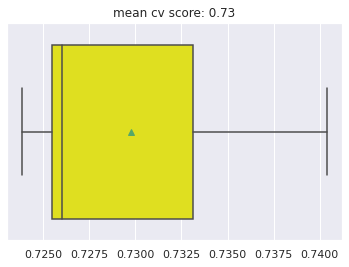

In [86]:
adc = AdaBoostClassifier(random_state=2)
cv_scores = cross_val_score(adc, Xc_train, y_train, scoring=scorer, cv=5, n_jobs=-1, error_score="raise")
sns.boxplot(cv_scores, color = "yellow", showmeans = True);
plt.title("mean cv score: " + str(np.round(cv_scores.mean(), 3)));

- cross validation accuracy is between 0.7225 and 0.7400, with the mean of 0.73.

In [87]:
adc, y_pred_train, y_pred_test, cvter_df.loc["adc",:] = compute_metrics(adc, Xc_train, Xc_test, y_train, y_test)
cvter_df.loc["adc",:]

Accuracy Train     0.73873
Accuracy Test     0.738046
Name: adc, dtype: object

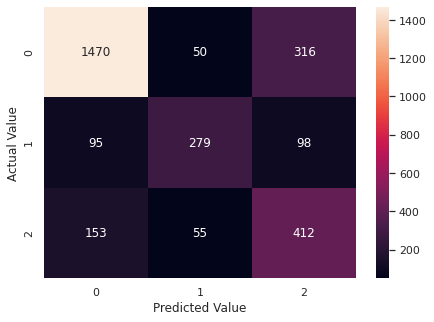

In [88]:
show_confusion_matrix(y_test, y_pred_test)

- Test accuracy is 0.738. No overfitting.

In [89]:
adc_tuned = AdaBoostClassifier(random_state=2)
para = {
    "n_estimators": np.arange(50, 400, 20),
    "learning_rate": [0.2, 0.4, 0.6, 0.8],
}
clf = RandomizedSearchCV(adc_tuned, param_distributions = para, n_iter=40, scoring=scorer, n_jobs=-1, cv=5, random_state = 10)
clf.fit(Xc_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 390, 'learning_rate': 0.6}
0.7733086509117589


In [90]:
adc_tuned, y_pred_train, y_pred_test, cvter_df.loc["adc_tuned",:] = compute_metrics(clf.best_estimator_, Xc_train, Xc_test, y_train, y_test)
cvter_df.loc["adc_tuned",:]

Accuracy Train    0.799607
Accuracy Test     0.781762
Name: adc_tuned, dtype: object

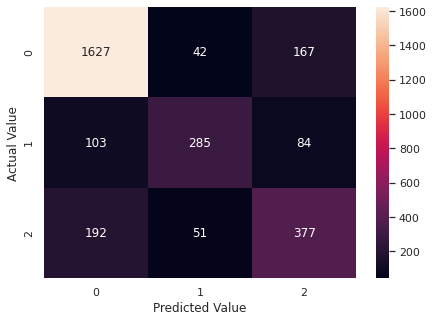

In [91]:
show_confusion_matrix(y_test, y_pred_test)

In [92]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1836
           1       0.75      0.60      0.67       472
           2       0.60      0.61      0.60       620

    accuracy                           0.78      2928
   macro avg       0.73      0.70      0.71      2928
weighted avg       0.78      0.78      0.78      2928



- After fine tuning, test accuracy is improved to 0.78. No overfitting. Based on the classification report, class 0 gains a good recall of 0.89, while class 1 and class 2 gains recall of about 0.6. For airline companies, identifying and promptly handling negative sentiments is more important than detecting positive or neutral sentiments. So the recall score of around 0.9 for negative sentiments is a desirable result.

### TfidfVectorizer

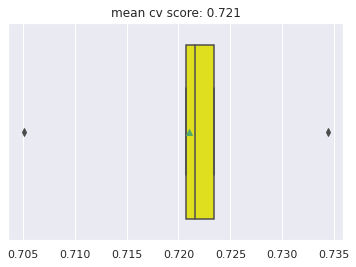

In [93]:
adc_new = AdaBoostClassifier(random_state=2)
cv_scores = cross_val_score(adc_new, Xt_train, y_train, scoring=scorer, cv=5, n_jobs=-1, error_score="raise")
sns.boxplot(cv_scores, color = "yellow", showmeans = True);
plt.title("mean cv score: " + str(np.round(cv_scores.mean(), 3)));

- cross validation accuracy is between 0.705 and 0.735, with the mean of 0.72.

In [94]:
adc_new, y_pred_train, y_pred_test, tvter_df.loc["adc",:] = compute_metrics(adc_new, Xt_train, Xt_test, y_train, y_test)
tvter_df.loc["adc",:]

Accuracy Train    0.732753
Accuracy Test     0.732923
Name: adc, dtype: object

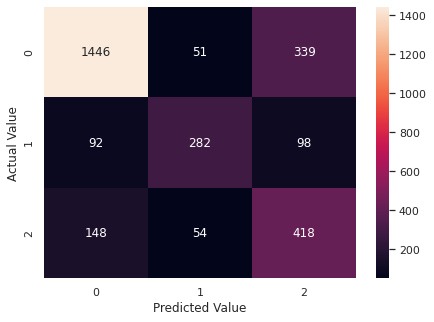

In [95]:
show_confusion_matrix(y_test, y_pred_test)

- Test accuracy is 0.73. No overfitting.

In [96]:
adc_tuned_new = AdaBoostClassifier(random_state=2)
para = {
    "n_estimators": np.arange(50, 400, 20),
    "learning_rate": [0.2, 0.4, 0.6, 0.8],
}
clf = RandomizedSearchCV(adc_tuned_new, param_distributions = para, n_iter=40, scoring=scorer, n_jobs=-1, cv=5, random_state = 10)
clf.fit(Xt_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 370, 'learning_rate': 0.4}
0.7636606013952931


In [97]:
adc_tuned_new, y_pred_train, y_pred_test, tvter_df.loc["adc_tuned",:] = compute_metrics(clf.best_estimator_, Xt_train, Xt_test, y_train, y_test)
tvter_df.loc["adc_tuned",:]

Accuracy Train    0.796107
Accuracy Test     0.776639
Name: adc_tuned, dtype: object

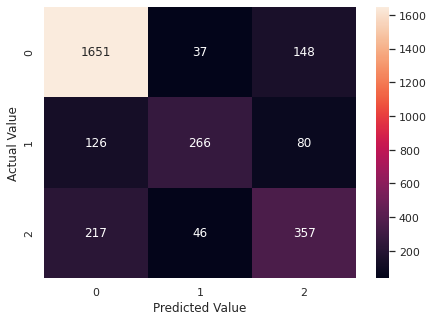

In [98]:
show_confusion_matrix(y_test, y_pred_test)

In [99]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1836
           1       0.76      0.56      0.65       472
           2       0.61      0.58      0.59       620

    accuracy                           0.78      2928
   macro avg       0.73      0.68      0.70      2928
weighted avg       0.77      0.78      0.77      2928



- After fine tuning, test accuracy is improved to 0.78. No overfitting. The classification report is similar to CountVectorizer.

## RandomForestClassifier
### CountVectorizer

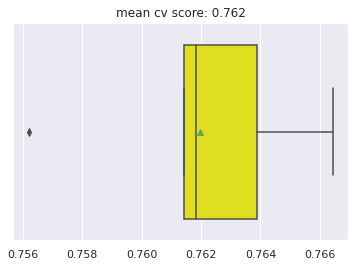

In [100]:
rfc = RandomForestClassifier(n_jobs = -1, class_weight = "balanced", random_state=2)
cv_scores = cross_val_score(rfc, Xc_train, y_train, scoring=scorer, cv=5, n_jobs=-1, error_score="raise")
sns.boxplot(cv_scores, color = "yellow", showmeans = True);
plt.title("mean cv score: " + str(np.round(cv_scores.mean(), 3)));

- cross validation accuracy is between 0.75 and 0.77, with the mean of 0.76.

In [101]:
rfc, y_pred_train, y_pred_test, cvter_df.loc["rfc",:] = compute_metrics(rfc, Xc_train, Xc_test, y_train, y_test)
cvter_df.loc["rfc",:]

Accuracy Train    0.987961
Accuracy Test     0.768101
Name: rfc, dtype: object

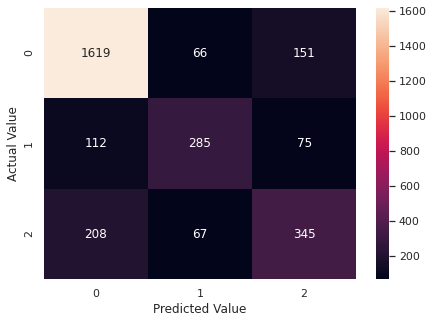

In [102]:
show_confusion_matrix(y_test, y_pred_test)

- Test accuracy is 0.77 and overfitting.

In [103]:
rfc_tuned = RandomForestClassifier(n_jobs = -1, class_weight = "balanced", random_state=2)
para = {
    "n_estimators": np.arange(100, 700, 100),
    "max_features": [0.5, 0.6, 0.7, "sqrt", "log2", None],
    "max_samples": [0.6, 0.7, 0.8, 0.9, 1],
    "max_depth": [3, 4, 5, 6, 7],
}
clf = RandomizedSearchCV(rfc_tuned, param_distributions = para, n_iter=40, scoring=scorer, n_jobs=-1, cv=5, random_state = 10)
clf.fit(Xc_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 300, 'max_samples': 0.7, 'max_features': 'log2', 'max_depth': 7}
0.7200297195017009


In [104]:
rfc_tuned, y_pred_train, y_pred_test, cvter_df.loc["rfc_tuned",:] = compute_metrics(clf.best_estimator_, Xc_train, Xc_test, y_train, y_test)
cvter_df.loc["rfc_tuned",:]

Accuracy Train    0.740949
Accuracy Test      0.73224
Name: rfc_tuned, dtype: object

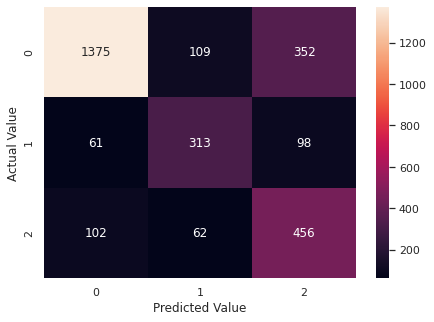

In [105]:
show_confusion_matrix(y_test, y_pred_test)

In [106]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1836
           1       0.65      0.66      0.65       472
           2       0.50      0.74      0.60       620

    accuracy                           0.73      2928
   macro avg       0.68      0.72      0.69      2928
weighted avg       0.77      0.73      0.74      2928



- After fine tuning, test accuracy is lowered to 0.73 but no more overfitting. Recall for each category is very balanced, about 0.7.

### TfidfVectorizer

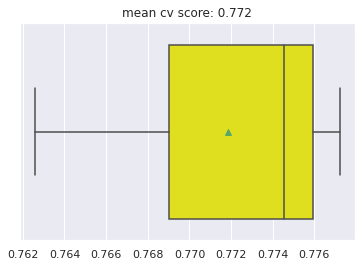

In [107]:
rfc_new = RandomForestClassifier(n_jobs = -1, class_weight = "balanced", random_state=2)
cv_scores = cross_val_score(rfc_new, Xt_train, y_train, scoring=scorer, cv=5, n_jobs=-1, error_score="raise")
sns.boxplot(cv_scores, color = "yellow", showmeans = True);
plt.title("mean cv score: " + str(np.round(cv_scores.mean(), 3)));

- cross validation accuracy is between 0.76 and 0.780, with the mean of 0.77.

In [108]:
rfc_new, y_pred_train, y_pred_test, tvter_df.loc["rfc",:] = compute_metrics(rfc_new, Xt_train, Xt_test, y_train, y_test)
tvter_df.loc["rfc",:]

Accuracy Train     0.98779
Accuracy Test     0.781762
Name: rfc, dtype: object

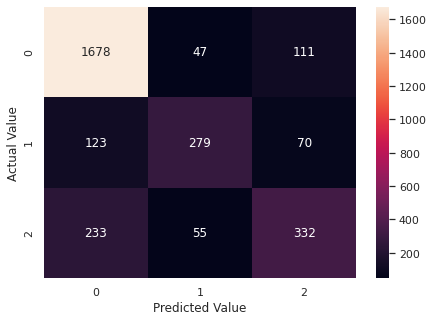

In [109]:
show_confusion_matrix(y_test, y_pred_test)

- Test accuracy is 0.78 and overfitting.

In [110]:
rfc_tuned_new = RandomForestClassifier(n_jobs = -1, class_weight = "balanced", random_state=2)
para = {
    "n_estimators": np.arange(100, 700, 100),
    "max_features": [0.5, 0.6, 0.7, "sqrt", "log2", None],
    "max_samples": [0.6, 0.7, 0.8, 0.9, 1],
    "max_depth": [3, 4, 5, 6, 7],
}
clf = RandomizedSearchCV(rfc_tuned_new, param_distributions = para, n_iter=40, scoring=scorer, n_jobs=-1, cv=5, random_state = 10)
clf.fit(Xt_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'n_estimators': 300, 'max_samples': 0.7, 'max_features': 'log2', 'max_depth': 7}
0.7242139585435913


In [111]:
rfc_tuned_new, y_pred_train, y_pred_test, tvter_df.loc["rfc_tuned",:] = compute_metrics(clf.best_estimator_, Xt_train, Xt_test, y_train, y_test)
tvter_df.loc["rfc_tuned",:]

Accuracy Train    0.752049
Accuracy Test     0.735314
Name: rfc_tuned, dtype: object

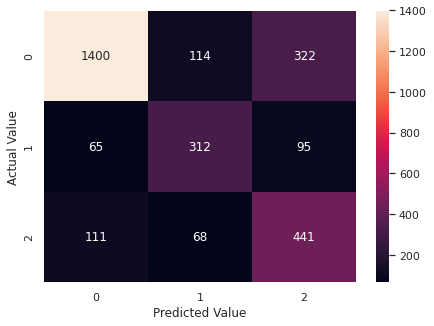

In [112]:
show_confusion_matrix(y_test, y_pred_test)

In [113]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1836
           1       0.63      0.66      0.65       472
           2       0.51      0.71      0.60       620

    accuracy                           0.74      2928
   macro avg       0.68      0.71      0.69      2928
weighted avg       0.77      0.74      0.75      2928



- After fine tuning, test accuracy is lowered to 0.74 but no more overfitting. The classification report is similar to CountVectorizer.

## Comparison of models

In [114]:
# save model to disk
model_to_file = [
    (adc, "adc.sav"), (adc_tuned, "adc_tuned.sav"), (rfc, "rfc.sav"), (rfc_tuned, "rfc_tuned.sav"),   # cout vector
    (adc_new, "adc_new.sav"), (adc_tuned_new, "adc_tuned_new.sav"), (rfc_new, "rfc_new.sav"), (rfc_tuned_new, "rfc_tuned_new.sav"),   # tf-idf vector
]

for model, filename in model_to_file:
    save_model(model, filename)

In [115]:
# # reload models from disk and fill the metrics dataframe
# for model, filename in model_to_file:
#     model = load_model(filename)

# adc, _, _, cvter_df.loc["adc",:] = compute_metrics(adc, Xc_train, Xc_test, y_train, y_test)  
# adc_tuned, _, _, cvter_df.loc["adc_tuned",:] = compute_metrics(adc_tuned, Xc_train, Xc_test, y_train, y_test)  
# rfc, _, _, cvter_df.loc["rfc",:] = compute_metrics(rfc, Xc_train, Xc_test, y_train, y_test)
# rfc_tuned, _, _, cvter_df.loc["rfc_tuned",:] = compute_metrics(rfc_tuned, Xc_train, Xc_test, y_train, y_test)

# adc_new, _, _, tvter_df.loc["adc",:] = compute_metrics(adc_new, Xt_train, Xt_test, y_train, y_test)  
# adc_tuned_new, _, _, tvter_df.loc["adc_tuned",:] = compute_metrics(adc_tuned_new, Xt_train, Xt_test, y_train, y_test)  
# rfc_new, _, _, tvter_df.loc["rfc",:] = compute_metrics(rfc_new, Xt_train, Xt_test, y_train, y_test)
# rfc_tuned_new, _, _, tvter_df.loc["rfc_tuned",:] = compute_metrics(rfc_tuned_new, Xt_train, Xt_test, y_train, y_test)

In [116]:
cvter_df.sort_values(by = "Accuracy Test", ascending = False)    # for CountVectorizer

,Accuracy Train,Accuracy Test
adc_tuned,0.799607,0.781762
rfc,0.987961,0.768101
adc,0.73873,0.738046
rfc_tuned,0.740949,0.73224


In [117]:
tvter_df.sort_values(by = "Accuracy Test", ascending = False)  # for TF-IDF vectorizer 

,Accuracy Train,Accuracy Test
rfc,0.98779,0.781762
adc_tuned,0.796107,0.776639
rfc_tuned,0.752049,0.735314
adc,0.732753,0.732923


- Optimal model for both vectorizers is adc_tuned.
- Optimal accuracy for both both types of vectorization is similar. After fine tuning it could achieve test accuracy of around 0.78. Let's print the the top 40 features of the optimal model: 

In [118]:
def display_top40_features(model, vectorizer, title):
    features = list(np.argsort(model.feature_importances_))
    features = features[::-1]  # sort feature indices in descending order according to feature importances
    features = features[:40]   # only tak the top 40 features

    top_40 = ""
    keywords = vectorizer.get_feature_names()

    for i in features:
        top_40 += "," + keywords[i]

    print("top 40 features:", top_40)
    plt.figure(figsize = (10, 10))
    plt.grid(False)
    plt.imshow(WordCloud(width=600, height=300,background_color = "white", stopwords = []).generate(top_40));
    plt.title("Wordcloud for top 40 features of " + title, fontsize = 30);

top 40 features: ,thank,not,love,awesome,amazing,delay,happy,need,flight,good,no,well,great,possible,say,cool,website,always,customer,rock,system,thx,glad,luggage,flight time,reservation,appreciate,minute,agent,call,bad,pay,far,hour,hi,suppose,would,sit,suck,helpful


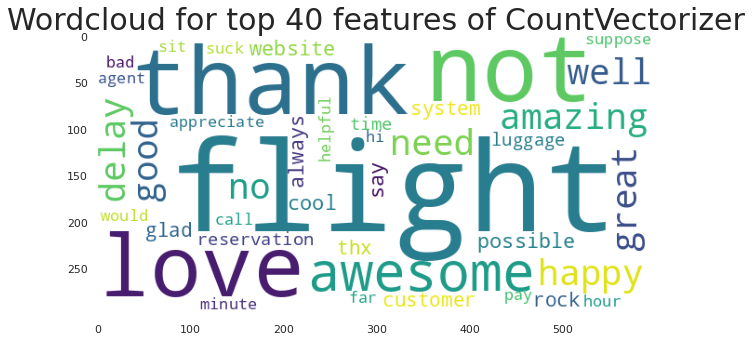

In [119]:
display_top40_features(adc_tuned, cvter, "CountVectorizer")  # for CountVectorizer

top 40 features: ,thank,not,love,awesome,amazing,delay,happy,need,flight,good,no,well,great,possible,say,cool,website,always,customer,rock,system,thx,glad,luggage,flight time,reservation,appreciate,minute,agent,call,bad,pay,far,hour,hi,suppose,would,sit,suck,helpful


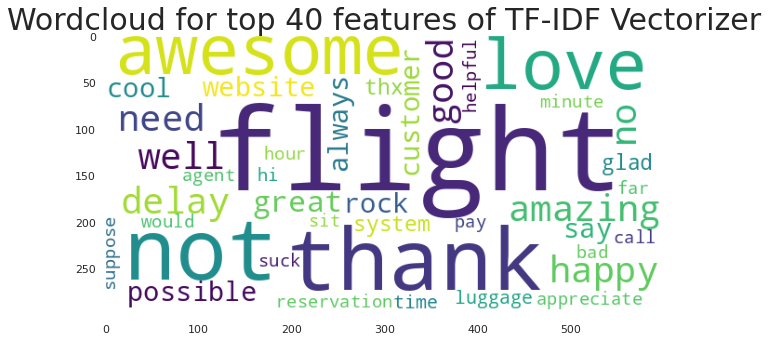

In [120]:
display_top40_features(adc_tuned, tvter, "TF-IDF Vectorizer")  # for TF-IDF Vectorizer

# VaderSentiment

- VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 
- VADER is unsupervised learning model. Without training, it makes predictions based on un-preprocessed text.
- Apply VADER on the same train and test set and compare the results with those of ensemble models.

In [121]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [122]:
def sentiment_score(score):
    return 1 if score >= 0.05 else 0 if score <= -0.05 else 2  # positive: score >= 0.05, negative: <= -0.05, neutral: -0.05 ~ 0.05

In [123]:
vader_train = airline.loc[X_train.index, "text"]    # training set text
vader_test = airline.loc[X_test.index, "text"]    # test set text
vader_train.head()

10618                     @USAirways yes. But the manner with which it was done was harsh for those affected. Already checked in. No remorse. Weak alternatives.
5617                                              @SouthwestAir you guys rock! So easy, quick, and affordable to change my flight. #bestairlineever #neverchange
14087                                                                                                                 @AmericanAir Great seats on this aircraft!
12175                                             @AmericanAir so you fail again flight to rdu sitting waiting on flight attendants. your logistics are not good
2756     @united already Flight Booking Problems next week's trip on @AmericanAir  thanks for making the choice so easy #disunited #unfriendlyskies #servicefail
Name: text, dtype: object

In [124]:
vader = SentimentIntensityAnalyzer()
y_pred_train = []
y_pred_test = []

for review in vader_train.values:
    score = vader.polarity_scores(review)
    y_pred_train.append(sentiment_score(score["compound"]))
    
for review in vader_test.values:
    score = vader.polarity_scores(review)
    y_pred_test.append(sentiment_score(score["compound"]))    

In [125]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy Train: ", accuracy_train)
print("Accuracy Test: ", accuracy_test)

Accuracy Train:  0.4948770491803279
Accuracy Test:  0.46994535519125685


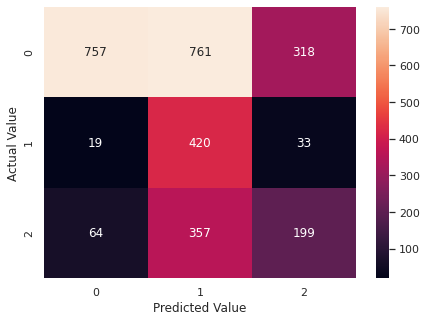

In [126]:
show_confusion_matrix(y_test, y_pred_test)

In [127]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.41      0.57      1836
           1       0.27      0.89      0.42       472
           2       0.36      0.32      0.34       620

    accuracy                           0.47      2928
   macro avg       0.51      0.54      0.44      2928
weighted avg       0.69      0.47      0.49      2928



- Accuracy is pretty low, which is under 0.5 for both train and test set. Recall for class 1 approaches 0.9, but recalls for the other two classes are under 0.5.

# RNN
- Apply RNN on pre-processed text and compare the result with previous models.

In [667]:
PYTHONHASHSEED=0
import random
random.seed(2)
np.random.seed(8)
import tensorflow
tensorflow.random.set_seed(6)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [668]:
def history_loss(history):
    """
    Plot training history.
    """
    plt.figure(figsize = (20,5));

    plt.subplot(121);   # plot accuracy curve
    plt.plot(history.history["accuracy"], label = "train");
    plt.plot(history.history["val_accuracy"], label = "validation");
    plt.legend(loc = "lower right");
    plt.title("Accuracy");

    plt.subplot(122);    # plot loss curve
    plt.plot(history.history["loss"], label = "train");
    plt.plot(history.history["val_loss"], label = "validation");
    plt.legend(loc = "upper right");
    plt.title("Loss");

In [669]:
word_embedding_dim = 5 # dimension of word embedding
num_classes = y_train.nunique()   # number of class labels

token = Tokenizer()
token.fit_on_texts(X_train)
print("The number of unique words in X_train: ", len(token.word_index)) 

The number of unique words in X_train:  10195


In [670]:
vocab_size = 6000   # the number of words in vocabulary

token = Tokenizer(num_words = vocab_size, oov_token = "<OOV>")
token.fit_on_texts(X_train)

train_sequence = token.texts_to_sequences(X_train)   # convert X_train to sequence of integers
test_sequence = token.texts_to_sequences(X_test)    # convert X_test to sequence of integers

In [671]:
lengths = [len(seq) for seq in train_sequence]
train_len = pd.DataFrame(lengths, columns = ["length of training sequences"])
train_len.describe()

,length of training sequences
count,11712.000000
mean,8.861595
std,3.837875
min,0.000000
25%,6.000000
50%,9.000000
75%,12.000000
max,21.000000


- Since the sequences are very short, pad all the sequences to the length of the longest sequence.

In [672]:
input_length = train_len["length of training sequences"].max()    # the maximum length of sequence
input_length

21

In [673]:
train_sequence = pad_sequences(train_sequence, maxlen = input_length, padding = "post", truncating="post")
test_sequence = pad_sequences(test_sequence, maxlen = input_length, padding = "post", truncating="post")

In [674]:
def build_model():
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = word_embedding_dim, input_length = input_length, 
                        embeddings_initializer= "he_normal"))
    model.add(Dropout(0.5))      
    model.add(Bidirectional(layer = LSTM(units = 2, kernel_initializer= "he_normal")))
    model.add(Dropout(0.5))     
    model.add(Dense(num_classes, activation='softmax'))
    opt = Adam(lr=0.0001, decay=1e-6) 

    model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = [scorer])
    
    model.summary()
    return model

In [675]:
m1 = build_model()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 21, 5)             30000     
_________________________________________________________________
dropout_50 (Dropout)         (None, 21, 5)             0         
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 4)                 128       
_________________________________________________________________
dropout_51 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_42 (Dense)             (None, 3)                 15        
Total params: 30,143
Trainable params: 30,143
Non-trainable params: 0
_________________________________________________________________


In [676]:
es = EarlyStopping(monitor='val_loss', mode = 'min', patience=5)
cp = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=0, mode='max', save_best_only=True)
history = m1.fit(x = train_sequence, y = y_train, epochs = 80, validation_split = 0.2, callbacks=[es, cp])  # save the best model with model checkpoint

Epoch 1/80
293/293 [==============================] - 5s 12ms/step - loss: 1.0684 - accuracy: 0.5890 - val_loss: 1.0338 - val_accuracy: 0.6261
Epoch 2/80
293/293 [==============================] - 3s 11ms/step - loss: 1.0092 - accuracy: 0.6271 - val_loss: 0.9756 - val_accuracy: 0.6261
Epoch 3/80
293/293 [==============================] - 3s 12ms/step - loss: 0.9665 - accuracy: 0.6271 - val_loss: 0.9351 - val_accuracy: 0.6261
Epoch 4/80
293/293 [==============================] - 4s 12ms/step - loss: 0.9386 - accuracy: 0.6277 - val_loss: 0.9064 - val_accuracy: 0.6261
Epoch 5/80
293/293 [==============================] - 4s 12ms/step - loss: 0.9170 - accuracy: 0.6283 - val_loss: 0.8834 - val_accuracy: 0.6261
Epoch 6/80
293/293 [==============================] - 4s 13ms/step - loss: 0.9051 - accuracy: 0.6292 - val_loss: 0.8621 - val_accuracy: 0.6261
Epoch 7/80
293/293 [==============================] - 4s 13ms/step - loss: 0.8854 - accuracy: 0.6320 - val_loss: 0.8406 - val_accuracy: 0.6261

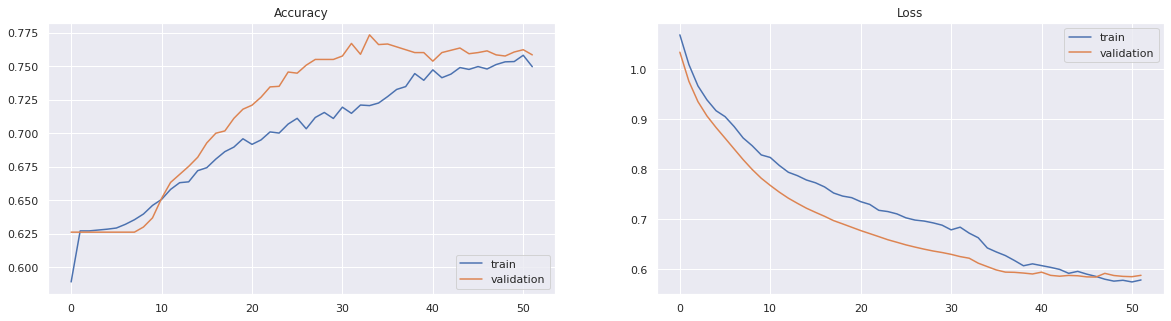

In [677]:
history_loss(history)

In [678]:
m1.load_weights("best_model.h5")
m1.evaluate(train_sequence, y_train)
m1.evaluate(test_sequence, y_test)

92/92 [==============================] - 0s 3ms/step - loss: 0.6183 - accuracy: 0.7671


[0.6182904243469238, 0.7670764923095703]

-  After 40 epochs, validation loss and accuracy flatten.

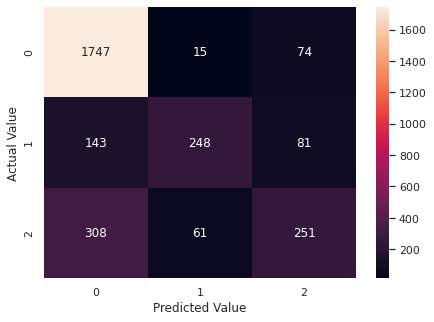

In [679]:
prediction = np.argmax(m1.predict(test_sequence), axis = -1)
show_confusion_matrix(y_test, prediction)

In [680]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.79      0.95      0.87      1836
           1       0.77      0.53      0.62       472
           2       0.62      0.40      0.49       620

    accuracy                           0.77      2928
   macro avg       0.73      0.63      0.66      2928
weighted avg       0.75      0.77      0.75      2928



- Test accuracy is 0.77. Performance is similar to fine tuned AdaBoostClassifier on bag of words.

# Conclusion

- This project tries to classify the sentiment on a text corpus from twitter with the reviews about 6 major US airlines.
- First, do EDA and text pre-processing. Then vectorize the text via Bag of Words model (CountVectorizer and TfidfVectorizer).
- After applying ensemble models on both vectorizers and fine tuning, the optimal model achieves test accuracy of 0.78. Both vectorizers show similar results.
- Finally the top 40 features are identified and showed by wordcloud.
- Additionally, try VADER on original text. Accuracy is undesirable, under 0.5.
- Additionally, apply RNN on preprocessed text. Test accuracy is 0.77. Performance is similar to fine tuned AdaBoostClassifier on bag of words.